# import

In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import datetime
from datetime import datetime
import re

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


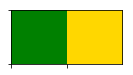

In [2]:

colors = ['green', 'gold']
sns.palplot(sns.color_palette(colors))

In [3]:
def analiz(n):
    """Функция находит медиану процентили, IQR,  и строит график распределения"""

    IQR = data[n].quantile(0.75) - data[n].quantile(0.25)
    perc25 = data[n].quantile(0.25)
    perc75 = data[n].quantile(0.75)
    print(
        '25-й перцентиль: {},'.format(perc25),
        '75-й перцентиль: {},'.format(perc75),
        "IQR: {}, ".format(IQR),
        "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    return data[n].describe(), data[n].hist()


def median_inp(col):
    """ Функция заменяет экстремальные значения в выбранном столбце на медиану"""
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    med = data[col].median()
    data[col] = data[col].apply(lambda x: med if x > (
        perc75 + 1.5*IQR) or x < (perc25 - 1.5*IQR) else x)
    return

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [5]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [6]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

Познакомимся с данными:

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [8]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [10]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [11]:
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
5,id_5,4.5
6,id_6,4.5
7,id_7,2.0
8,id_8,2.0
9,id_9,3.5


In [12]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [13]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


В данных у нас всего 3 числовых столбца, остальные 7 object. Числовые очистим, из нечисловых попробуем извлечь информацию для образования числовых признаков, чтобы можно было их использовать в модели.

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [15]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
23244,id_12921,London,"['Italian', 'Pizza', 'Mediterranean', 'Vegetar...",12931.0,$$ - $$$,109.0,"[['One of thevery best', 'pizza yes please'], ...",/Restaurant_Review-g186338-d3568307-Reviews-Tr...,d3568307,1,3.5
14171,id_1080,Oporto,"['European', 'Portuguese']",1081.0,$$ - $$$,4.0,"[[""It's closed"", 'Lovely bakery and cafe'], ['...",/Restaurant_Review-g189180-d8571494-Reviews-Co...,d8571494,1,4.5
8595,id_8595,Paris,NaN,4459.0,NaN,18.0,"[['very helpful proprietor'], ['04/28/2017']]",/Restaurant_Review-g187147-d5582192-Reviews-Au...,d5582192,0,0.0
46177,id_152,Budapest,"['French', 'European', 'Hungarian', 'Vegetaria...",153.0,$$ - $$$,64.0,"[['Perfect breakfast', 'Lovely atmosphere, gre...",/Restaurant_Review-g274887-d12201267-Reviews-S...,d12201267,1,5.0
18482,id_5758,Berlin,NaN,5760.0,NaN,7.0,"[['Few will match this!', 'Best ice cream in B...",/Restaurant_Review-g187323-d8386594-Reviews-Gi...,d8386594,1,3.5


Посмотрим на данные: оценим количество пропущенных значений в столбцах в текстовом виде и визуально:

Restaurant_id - 0.0%
City - 0.0%
Cuisine Style - 23.0%
Ranking - 0.0%
Price Range - 35.0%
Number of Reviews - 6.0%
Reviews - 0.0%
URL_TA - 0.0%
ID_TA - 0.0%
sample - 0.0%
Rating - 0.0%


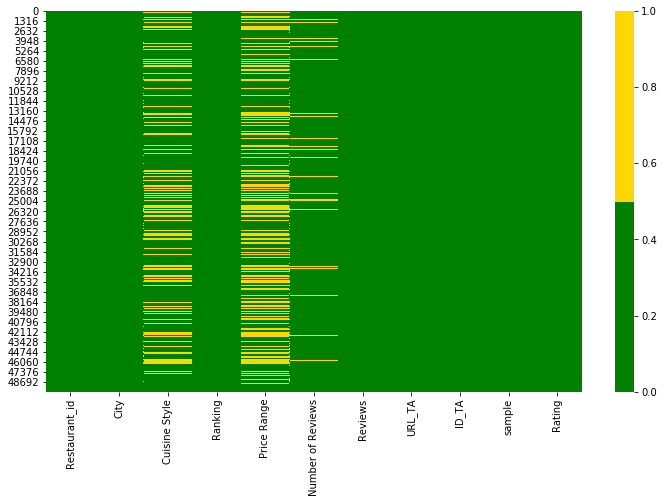

In [16]:
cols = data.columns
fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(data[cols].isnull(), cmap=sns.color_palette(colors))

# Количество пропусков в процентах по столбцам:
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    print(f'{col} - {round(pct_missing*100)}%')

In [17]:
# Посмотрим на структуру данных в столбце 'Reviews',здесь есть даты, в дальнейшем извлечем их для создания нового признака
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [18]:
#Заполним пропуски в этом столбце  позже
data['Reviews'].isna().sum()

2

In [19]:
# Посчитаем пропуски в столбце 'Number of Reviews'
data['Number of Reviews'].isna().sum()

3200

В столбце data['Number of Reviews'] 3200 пропусков, сформируем отдельный числовой столбец из пропусков где пропуски 1, остальные 0. И получим новый дополнительный признак: 'Number_of_Reviews_isNAN'

In [20]:
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
data['Number_of_Reviews_isNAN'].value_counts()

0    46800
1     3200
Name: Number_of_Reviews_isNAN, dtype: int64

По такому же принципу получим еще один дополнительный признак 'Price RangeNAN', так как там пропусков тоже достаточно много

In [21]:
data['Price RangeNAN'] = pd.isna(data['Price Range']).astype('uint8')
data['Price RangeNAN'].value_counts()

0    32639
1    17361
Name: Price RangeNAN, dtype: int64

In [22]:
# Далее заполняем пропуски средним, 
data['Number of Reviews'].fillna(round(data['Number of Reviews'].mean()), inplace=True) #среднее работало лучше среднего по городу
data['Number of Reviews'] = data['Number of Reviews'].fillna(round(data.groupby('City')['Number of Reviews'].transform('mean')))
data.loc[data['Number_of_Reviews_isNAN']==1]

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Price RangeNAN
7,id_7,Budapest,NaN,2330.0,NaN,124.0,"[[], []]",/Restaurant_Review-g274887-d8286886-Reviews-Be...,d8286886,0,0.0,1,1
25,id_25,Madrid,NaN,5828.0,NaN,124.0,"[[], []]",/Restaurant_Review-g187514-d13202032-Reviews-W...,d13202032,0,0.0,1,1
53,id_53,Prague,NaN,2095.0,NaN,124.0,"[[], []]",/Restaurant_Review-g274707-d7124128-Reviews-Ch...,d7124128,0,0.0,1,1
74,id_74,Prague,"['Cafe', 'European', 'Czech']",2052.0,$,124.0,"[[""Nova' Doba""], ['01/26/2017']]",/Restaurant_Review-g274707-d12032989-Reviews-C...,d12032989,0,0.0,1,0
81,id_81,Barcelona,"['Peruvian', 'South American']",4325.0,$$ - $$$,124.0,"[[], []]",/Restaurant_Review-g187497-d10088997-Reviews-N...,d10088997,0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49965,id_5720,Rome,NaN,5722.0,NaN,124.0,"[[], []]",/Restaurant_Review-g187791-d793376-Reviews-Wes...,d793376,1,5.0,1,1
49972,id_2009,Prague,"['Cafe', 'Delicatessen', 'Healthy', 'Wine Bar'...",2012.0,$,124.0,"[['Personal expirence'], ['10/27/2017']]",/Restaurant_Review-g274707-d12981295-Reviews-M...,d12981295,1,5.0,1,0
49986,id_7274,Madrid,NaN,7279.0,NaN,124.0,"[[], []]",/Restaurant_Review-g187514-d12182212-Reviews-C...,d12182212,1,3.0,1,1
49988,id_4968,Berlin,NaN,4970.0,NaN,124.0,"[[], []]",/Restaurant_Review-g187323-d7761701-Reviews-Ar...,d7761701,1,4.0,1,1


25-й перцентиль: 10.0, 75-й перцентиль: 124.0, IQR: 114.0,  Границы выбросов: [-161.0, 295.0].


(count    50000.000000
 mean       124.441040
 std        284.546908
 min          2.000000
 25%         10.000000
 50%         38.000000
 75%        124.000000
 max       9660.000000
 Name: Number of Reviews, dtype: float64,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdd554136a0>)

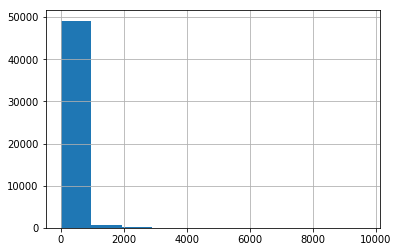

In [23]:
analiz('Number of Reviews')
# Видим, что в столбце есть выбросы, но попытка избавиться от них почему-то ухудшает MAE, оставим

In [24]:
# Попутно получим еще один дополнительный полиномильный признак из этого столбца, он немного улучшил значение MAE
data['Number of Reviews_poly'] = data['Number of Reviews']**2

Дополнительный признак 'price_range': data['price_range'] оцифрованный уровень цен, от 1 до 3, пустые значения заполним медианой

In [25]:
# Заметим, что в столбце 3 типа цен: дешевые, средние и дорогие. Создадим новый числовой признак где: $=1,$$-$$$=2,$$$$=3 
#Больше всего средних цен, поэтому и заполним пропуски медианой
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [26]:
data['Price Range'] = data['Price Range'].replace('$',1)
data['Price Range'] = data['Price Range'].replace('$$ - $$$',2)
data['Price Range'] = data['Price Range'].replace('$$$$',3)
data['price_range'] = data['Price Range']
data['price_range'].fillna(data['Price Range'].median(), inplace= True)

In [27]:
data['price_range']

0        2.0
1        2.0
2        2.0
3        3.0
4        3.0
        ... 
49995    2.0
49996    2.0
49997    2.0
49998    2.0
49999    2.0
Name: price_range, Length: 50000, dtype: float64

Дополнительный признак 'city_num': data['city_num'] оцифрованный названия городов от 1 до 31. Думаю признак создан не совсем правильно,тут скорее нужно ввести dummy переменные, но он улучшает модель

In [28]:
import numpy as np
city = pd.DataFrame(data['City'].value_counts())
city['number']= np.arange(1,32)


city1=[]
for elem in data['City']:
    k =city.loc[elem].number
    city1.append(k)
    
data['city_num'] = pd.DataFrame(city1)

Дополнительный признак 'num_cus': data['num_cus'] количество кухонь в одном ресторане, значения Nan заменены на среднее количество кухонь в ресторанах.

In [29]:
# Среднее количество кухонь в одном ресторане (вычисляем, для заполнения пустых значений):
cus = set()
list_cus = []
data['Cuisine Style'] = data['Cuisine Style'].fillna(value = 'Non')
for string in data['Cuisine Style']:
    r = string.replace('[','')
    l = r.replace(']','')
    k = l.split(',')
    for elem in k:
        if elem != 'nan':
            cus.add(elem)
            list_cus.append(elem)
        
round(len(list_cus)/ len(data['Cuisine Style']),1)

2.6

In [30]:
num_cus =[]
data['cuisine Style'] = data['Cuisine Style'].fillna(value = '2.6')
for string in data['cuisine Style']:
    if string != '2.6':
        
        r = string.replace('[','')
        l = r.replace(']','')
        k = l.split(',')
        d = len(k)
        num_cus.append(d)
    elif string == '2.6':
        
        num_cus.append(2.6)
        
data['num_cus'] = pd.DataFrame(num_cus)

In [31]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Price RangeNAN,Number of Reviews_poly,price_range,city_num,cuisine Style,num_cus
29765,id_12900,London,Non,12910.0,NaN,5.0,"[['A Pleasant and Enjoyable Lunch', 'good rang...",/Restaurant_Review-g186338-d10179115-Reviews-I...,d10179115,1,3.5,0,1,25.0,2.0,1,Non,1
9508,id_9508,Rome,Non,5728.0,NaN,2.0,"[['Amazing baked goods'], ['01/11/2013']]",/Restaurant_Review-g187791-d3751368-Reviews-Pa...,d3751368,0,0.0,0,1,4.0,2.0,7,Non,1
13178,id_11198,London,Non,11208.0,NaN,11.0,"[['A great place for relax and rest', 'Good fo...",/Restaurant_Review-g186338-d5080712-Reviews-Ea...,d5080712,1,3.5,0,1,121.0,2.0,1,Non,1
15830,id_8421,London,"['Pizza', 'International', 'European']",8430.0,2.0,45.0,"[['OK', 'Nice burgers and vegan option'], ['09...",/Restaurant_Review-g186338-d3326920-Reviews-El...,d3326920,1,3.5,0,0,2025.0,2.0,1,"['Pizza', 'International', 'European']",3
10736,id_686,Brussels,Non,687.0,NaN,26.0,"[['Decent food, good drinks but quite expensi....",/Restaurant_Review-g950786-d11029213-Reviews-L...,d11029213,1,4.5,0,1,676.0,2.0,12,Non,1


Дополнительный признак time_delta: Из столбца 'Reviews'с помощью модуля datetime можно вытащить значения дат отзывов и найти разницу между ними.data['time_delta'] оцифрованная разница во времени между отзывами. Пустые значения заменены на медиану.

In [32]:
#Вспомним про 2 пропуска в столбце 'Reviews', и заполним их, чтобы не выдавали ошибку при обработке:
data['Reviews'].fillna('empty', inplace=True)

In [33]:
data['Reviews']

0                                                 [[], []]
1        [['Very good reviews!', 'Fine dining in Hakani...
2        [['Better than the Links', 'Ivy Black'], ['12/...
3        [['Most exquisite', 'Delicious and authentic']...
4        [['Always the best in bratislava', 'Very good ...
                               ...                        
49995    [['The real Italian experience!', 'Wonderful f...
49996    [['Parisian atmosphere', 'Bit pricey but inter...
49997    [['Good by swedish standards', 'A hidden jewel...
49998    [['Underground restaurant', 'Oldest Restaurant...
49999    [['Average', 'Nice an informal'], ['01/31/2016...
Name: Reviews, Length: 50000, dtype: object

In [34]:
date_str =[]
pattern = re.compile('\d\d/\d\d/\d\d\d\d')
for string in data['Reviews']:
    c = pattern.findall(string)
    date_str.append(c)
data['reviews_date']=date_str    

time_delta = []
delta1 = datetime.strptime(data['reviews_date'][1][0],'%m/%d/%Y')
delta2 = datetime.strptime(data['reviews_date'][1][1],'%m/%d/%Y')
delta=delta1-delta2
for num in data['reviews_date']:
        if len(num)>1:
            k1=datetime.strptime(num[0],'%m/%d/%Y')
            k2=datetime.strptime(num[1],'%m/%d/%Y')
            k3=k1-k2
            time_delta.append(k3)
        elif len(num) ==1:
            time_delta.append(0)
        elif len(num)<1:
            time_delta.append('nan')
len(time_delta)        

50000

In [35]:
data['time_delta'] = pd.DataFrame(time_delta)
data['time_delta'] = data['time_delta'].dt.days
data['time_delta'].median()

38.0

In [36]:
data['time_delta'] = data['time_delta'].fillna(data['time_delta'].median())

25-й перцентиль: 7.0, 75-й перцентиль: 105.0, IQR: 98.0,  Границы выбросов: [-140.0, 252.0].


(count    50000.000000
 mean        96.486700
 std        203.727059
 min       -362.000000
 25%          7.000000
 50%         38.000000
 75%        105.000000
 max       3296.000000
 Name: time_delta, dtype: float64,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdd552f9cc0>)

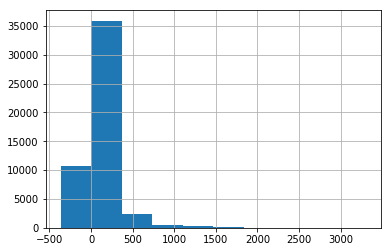

In [37]:
analiz('time_delta')

In [38]:
#Есть отрицательные значения времени(скорее всего порядок отзывов нарушен), исправим это:
data['time_delta'] = data['time_delta'].apply(lambda x: abs(x))

In [39]:
# Попробуем убрать выбросы timedelta:
#median_inp('time_delta')
# в итоге выбросы решил оставить, так как это ухудшило результаты работы модели

Дополнительный признак 'chain_rest': data[chain_rest] сетевой ресторан или нет, сформируем новый столбец и заполним единицами, если id ресторана присутствует более одного раза:

In [40]:
chain_rest_list = list(data['Restaurant_id'].value_counts()[
    data['Restaurant_id'].value_counts() > 1].index)

# Если сетевой, добавим ему идентификатор 1, если нет 0
data['chain_rest'] = data[data['Restaurant_id'].isin(
    chain_rest_list)]['Restaurant_id'].apply(lambda x: 1)
data['chain_rest'] = data['chain_rest'].fillna(0)

data['chain_rest'].value_counts()

1.0    46193
0.0     3807
Name: chain_rest, dtype: int64

In [41]:
data['chain_rest'].shape

(50000,)

Создадим дополительный признак  'rank_num' : количество Ranking/кол-во отзывов


In [42]:
#data['rank_num']= data['Ranking']/data['Number of Reviews']
# дает ухудшение MAE(, исключим его из модели и не будем использовать

Создадим дополительный полиномиальный  признак 'rank_kvad' : количество Ranking**2, что дает немного улучшить MAE)

In [43]:
data['rank_kvad']= data['Ranking']**2
data['rank_kvad']

0        168039369.0
1            11236.0
2           656100.0
3          2785561.0
4             1369.0
            ...     
49995       250000.0
49996     40208281.0
49997      2729104.0
49998       410881.0
49999     23299929.0
Name: rank_kvad, Length: 50000, dtype: float64

In [44]:
data['Ranking'].describe()

count    50000.000000
mean      3664.427520
std       3700.092452
min          1.000000
25%        972.000000
50%       2278.000000
75%       5241.000000
max      16444.000000
Name: Ranking, dtype: float64

 Получим еще один признак 'norm_Ranking_on_Rest_in_City' в итоге он больше всего оказывает влияние на нашу модель.

Text(0.5, 0, 'Ranking')

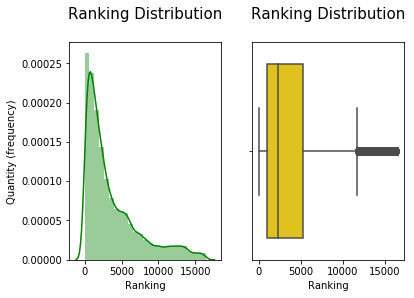

In [45]:
plt.subplot(121)
sns.distplot(data['Ranking'].values, bins=25, color=colors[0])
plt.title('Ranking Distribution\n', fontsize=15)
plt.xlabel('Ranking')
plt.ylabel('Quantity (frequency)')

plt.subplot(122)
sns.boxplot(data['Ranking'].values, color=colors[1])
plt.title('Ranking Distribution\n', fontsize=15)
plt.xlabel('Ranking')

In [46]:
# Ranking имеет нормальное распределение, 
# просто в больших городах больше ресторанов, из-за мы этого имеем смещение
# необходимо отнормировать критерий Ranking по городам City
mean_Ranking_on_City = data.groupby(['City'])['Ranking'].mean()
count_Restorant_in_City = data['City'].value_counts(ascending=False)
data['mean_Ranking_on_City'] = data['City'].apply(lambda x: mean_Ranking_on_City[x])
data['count_Restorant_in_City'] = data['City'].apply(lambda x: count_Restorant_in_City[x])
data['norm_Ranking_on_Rest_in_City'] = (data['Ranking'] - data['mean_Ranking_on_City']) / data['count_Restorant_in_City']

Дополнительный признак 'Have_review': есть ли отзывы о ресторане, простенький, но тоже сделал MAE  чуть лучше

In [47]:
#наличие отзывов, если есть отзывы в поле Reviews, тогда 1 , иначе 0
pats = re.compile('\w+\s*\w*\s*\w*')
data['Have_review'] = data['Reviews'].apply(lambda x: ['default'] if pd.isnull(x) else pats.findall(x))
data['Have_review']=data['Have_review'].str[0].replace(pats, 1)
data['Have_review']=data['Have_review'].fillna(0) 

Еще 2 дополнительных признака: количество ресторанов в городе и новый Ranking, делит ранг ресторана на количество ресторанов в городе:

In [48]:
# количество рестаранов на в городе
data['rest_count'] = data['City'].map(data.groupby(['City'])['City'].count().to_dict())
# Ранги (Ranking)
data['relative_ranking'] = data['Ranking']/data['rest_count']

Пробовал еще ввести полиномиальные признаки, но сделал вывод, что полиномиальный признак от искусствено созданно признака ухудшает модель. Так же если по столбцу сгенерить более одного полиномиального признака, так же ухудшает модель. Поэтому от следующих двух признаков отказался.

In [49]:
#data['relative_ranking_poly'] = data['relative_ranking']**2

In [50]:
#import math
#data['rank_sqrt']= data['Ranking']**(1/2)
# Не будем использовать, так как ухудшает MAE

Создадим dummy переменные из столбца 'City'. У нас 31 город значит появится 31 новый признак.

In [51]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [52]:
data.head(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,id_0,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
13157,id_1255,"['Central European', 'Hungarian', 'European', ...",1256.0,1.0,29.0,[['Student Training Restaurant with a differ.....,/Restaurant_Review-g274887-d5260172-Reviews-Al...,d5260172,1,4.5,...,0,0,0,0,0,0,0,0,0,0
1942,id_1942,['Sushi'],918.0,NaN,2.0,"[['Great fresh sushi'], ['08/02/2017']]",/Restaurant_Review-g274856-d12681305-Reviews-P...,d12681305,0,0.0,...,0,0,0,0,0,0,0,1,0,0
40651,id_383,"['French', 'European', 'Vegetarian Friendly']",384.0,2.0,818.0,"[['good experience and food', 'Yes, the Aligot...",/Restaurant_Review-g187147-d695125-Reviews-L_A...,d695125,1,4.0,...,0,0,1,0,0,0,0,0,0,0
4670,id_4670,"['Dutch', 'Cafe', 'European']",1092.0,1.0,25.0,"[['So many baked goods - so little time!', 'Fr...",/Restaurant_Review-g188590-d10211193-Reviews-B...,d10211193,0,0.0,...,0,0,0,0,0,0,0,0,0,0
49609,id_1324,"['Lebanese', 'Mediterranean', 'Middle Eastern'...",1325.0,2.0,132.0,"[['Avoid.', 'Dinner for 2'], ['08/25/2017', '0...",/Restaurant_Review-g189158-d2182775-Reviews-Fe...,d2182775,1,3.5,...,0,0,0,0,0,0,0,0,0,0


# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

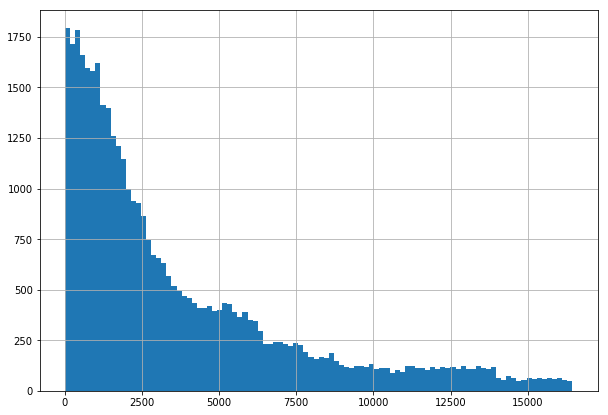

In [54]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

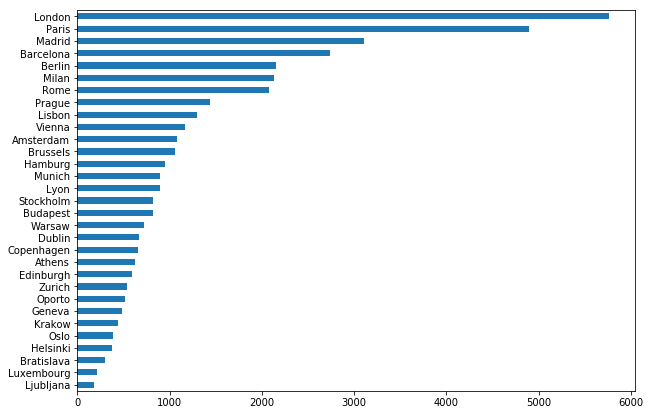

In [55]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

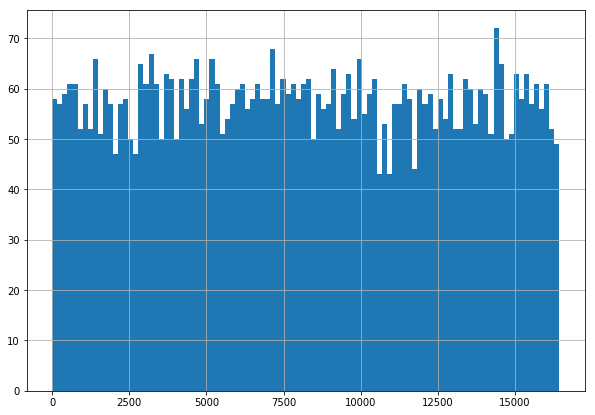

In [56]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

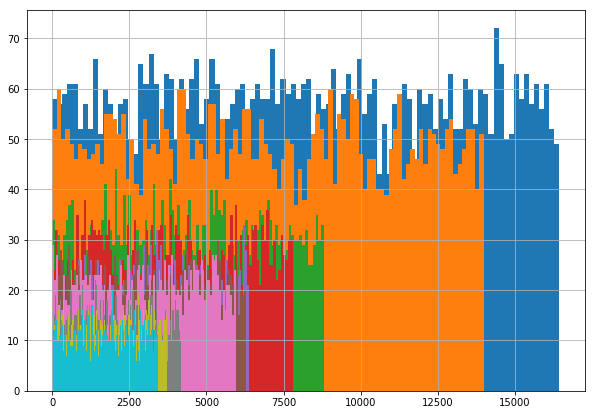

In [57]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.




### Посмотрим распределение целевой переменной

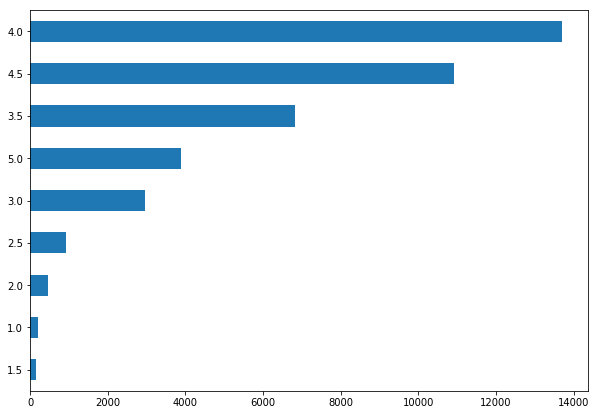

In [58]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

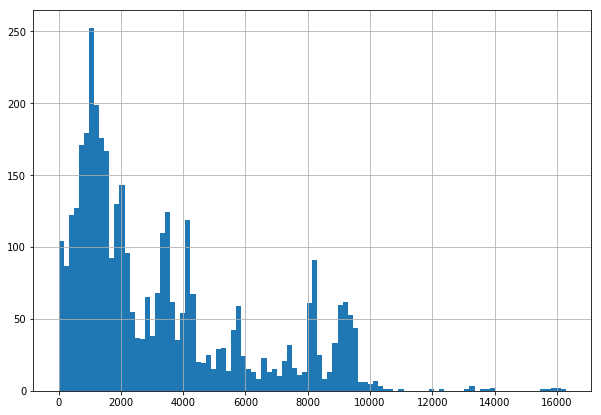

In [59]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

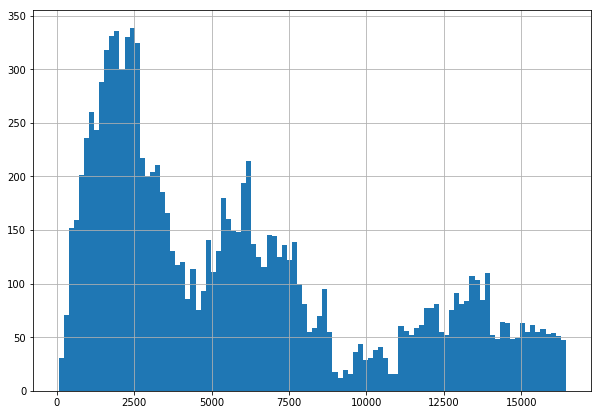

In [60]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

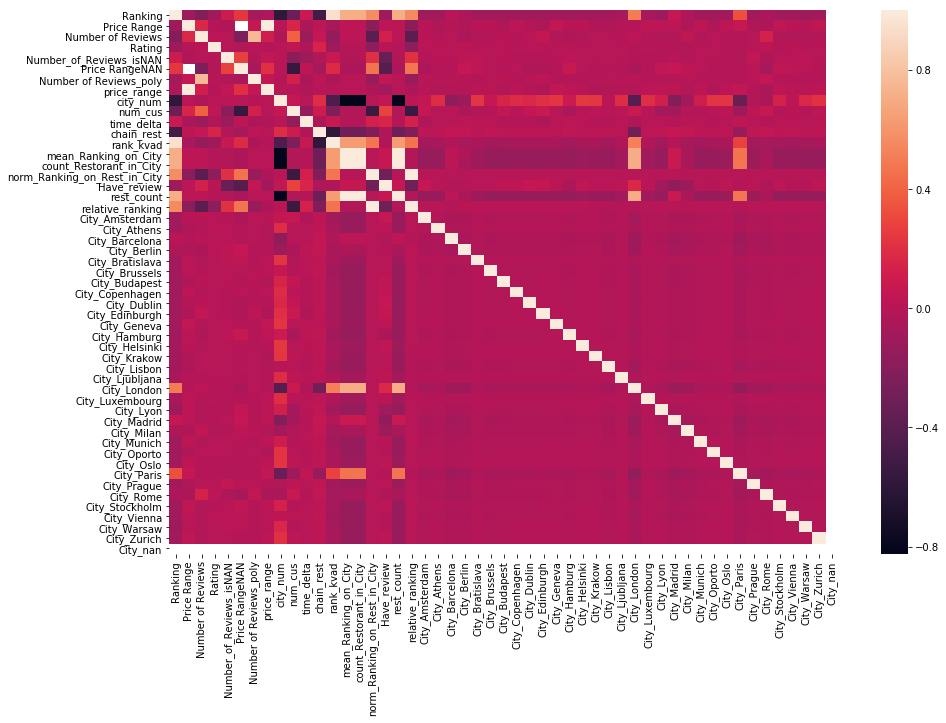

In [61]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?



# Data Preprocessing


In [62]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
49529,id_953,"['Italian', 'Seafood', 'Mediterranean', 'Veget...",955.0,2.0,142.0,"[['Nice diner', 'Amazing Milanese restaurant']...",/Restaurant_Review-g187849-d9466346-Reviews-Ol...,d9466346,1,4.5,...,0,0,0,0,0,0,0,0,0,0
44365,id_321,Non,323.0,NaN,14.0,"[['GREAT reception for friends', 'Friendly and...",/Restaurant_Review-g188057-d10172242-Reviews-L...,d10172242,1,5.0,...,0,0,0,0,0,0,0,0,0,0
4562,id_4562,"['Sushi', 'Chinese', 'Japanese']",1570.0,3.0,24.0,"[['Great sushi and service', 'Never fails to d...",/Restaurant_Review-g189541-d803417-Reviews-Hin...,d803417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
9796,id_9796,['Spanish'],1825.0,3.0,4.0,"[['Excellent Food', 'Small and romantic spanis...",/Restaurant_Review-g187265-d1018001-Reviews-Al...,d1018001,0,0.0,...,0,0,0,0,0,0,0,0,0,0
19051,id_6044,"['Mexican', 'Spanish']",6047.0,NaN,36.0,"[[], []]",/Restaurant_Review-g187514-d6855169-Reviews-El...,d6855169,1,3.5,...,0,0,0,0,0,0,0,0,0,0


Исключим из модели все нецифровые столбцы:

In [63]:
data1 =data.drop(['Restaurant_id', 'Cuisine Style','Price Range','Reviews', 'URL_TA', 'ID_TA','cuisine Style','reviews_date'],axis =1)

In [64]:
# Теперь выделим тестовую часть
train_data = data1.query('sample == 1').drop(['sample'], axis=1)
test_data = data1.query('sample == 0').drop(['sample'], axis=1)


y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [65]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [66]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape, 

((10000, 50), (40000, 50), (40000, 49), (32000, 49), (8000, 49))

# Model 
Сам ML

In [67]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [68]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [69]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [70]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20631624999999998


### Я не стал использовать внешние данные для моделирования и получил результат MAE 0.2063. На kaggle в открытой таблице результат несколько хуже, возможно в private он будет ближе к моему, интересно узнать.
Думаю, используя такие внешние данные, как население городов, является ли город столицей, можно добиться показателя MAE 0.17-0.18


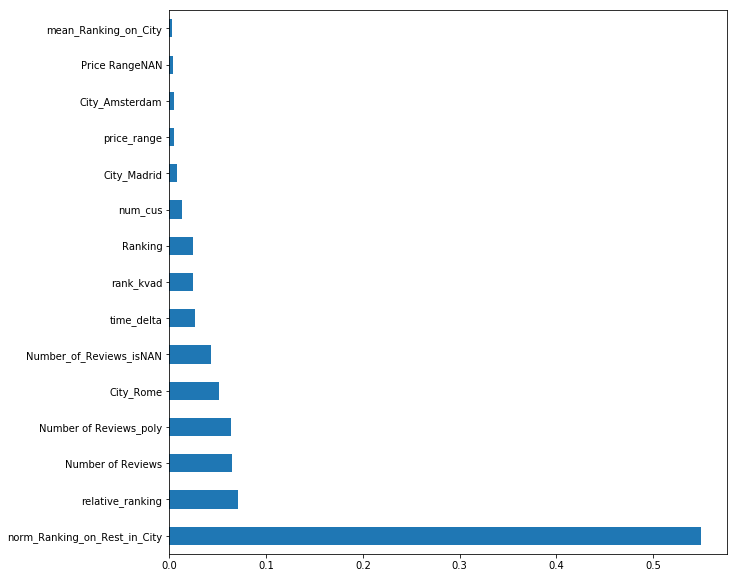

In [71]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [72]:
display(data.head())
test_data.head(10)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,id_0,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,0


,Ranking,Number of Reviews,Rating,Number_of_Reviews_isNAN,Price RangeNAN,Number of Reviews_poly,price_range,city_num,num_cus,time_delta,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,12963.0,4.0,0.0,0,0,16.0,2.0,2,2,38.0,...,0,0,1,0,0,0,0,0,0,0
1,106.0,97.0,0.0,0,0,9409.0,2.0,28,5,37.0,...,0,0,0,0,0,0,0,0,0,0
2,810.0,28.0,0.0,0,0,784.0,2.0,22,1,22.0,...,0,0,0,0,0,0,0,0,0,0
3,1669.0,202.0,0.0,0,0,40804.0,3.0,1,5,14.0,...,0,0,0,0,0,0,0,0,0,0
4,37.0,162.0,0.0,0,0,26244.0,3.0,29,6,15.0,...,0,0,0,0,0,0,0,0,0,0
5,5093.0,24.0,0.0,0,0,576.0,1.0,2,3,5.0,...,0,0,1,0,0,0,0,0,0,0
6,3704.0,2.0,0.0,0,0,4.0,1.0,9,2,38.0,...,0,0,0,0,0,0,0,0,0,0
7,2330.0,124.0,0.0,1,1,15376.0,2.0,17,1,38.0,...,0,0,0,0,0,0,0,0,0,0
8,771.0,2.0,0.0,0,1,4.0,2.0,28,2,88.0,...,0,0,0,0,0,0,0,0,0,0
9,605.0,13.0,0.0,0,1,169.0,2.0,16,1,34.0,...,0,0,0,0,0,1,0,0,0,0


In [73]:
test_data = test_data.drop(['Rating'], axis=1)

In [74]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [75]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [76]:
predict_submission

array([3.12 , 4.27 , 4.48 , ..., 3.065, 4.47 , 4.235])

In [77]:
len(predict_submission)

10000

In [78]:
sample_submission['Rating'] = predict_submission
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.120
1,id_1,4.270
2,id_2,4.480
3,id_3,4.300
4,id_4,4.490
5,id_5,4.440
6,id_6,2.525
7,id_7,2.915
8,id_8,4.240
9,id_9,4.705


In [79]:

sample_submission.to_csv('submission.csv', index=False)
